[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)

#### Timescales comparison 
##### Bolin
##### Gedzelman

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from PySDM.physics import si
from PySDM import Formulae
from PySDM_examples.Bolin_1958.common import IsotopeTimescaleCommon
from open_atmos_jupyter_utils import show_plot
import pandas as pd

In [3]:
any_non_zero_value = 44.0
radii = np.asarray([0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.20]) * si.cm
temperature = Formulae().constants.T0 + 10 * si.K

settings = {
    "terminal_velocity":"RogersYau",
    "drop_growth":"Mason1951",
    "diffusion_thermics":"Neglect",
    "saturation_vapour_pressure":"AugustRocheMagnus",
    "ventilation":"Froessling1938",
    "particle_shape_and_density":"LiquidSpheres",
    "air_dynamic_viscosity":"ZografosEtAl1987",
}

variants = {
    'bolin': {
        'constants': {"BOLIN_ISOTOPE_TIMESCALE_COEFF_C1": 1.63},
        'isotope_relaxation_timescale': "Bolin1958",
    },
    'miyake': {
        'isotope_relaxation_timescale': "MiyakeEtAl1968",
    }
}

adjustment_time = pd.DataFrame({'radius [cm]':radii})

In [4]:
## Bolin & Miyake

In [5]:
for variant, kwargs in variants.items():
    new_settings = {**kwargs, **settings}
    iso_func = IsotopeTimescaleCommon(settings=new_settings, temperature=temperature, radii=radii)
    r_dr_dt = iso_func.r_dr_dt_fun(K=any_non_zero_value)
    adjustment_time[variant] = iso_func.formulae.isotope_relaxation_timescale.tau_of_rdrdt(
        radius = radii,
        r_dr_dt = r_dr_dt(RH=0, RH_eq=1, lv=0),
        alpha=1
    )

## Bolin - check c1

In [6]:
iso_func = IsotopeTimescaleCommon(settings={**settings, **variants['bolin']}, temperature=temperature, radii=radii)
r_dr_dt = iso_func.r_dr_dt_fun(K=any_non_zero_value)

vent_coeff = iso_func.vent_coeff_fun()
alpha = 0.75
c1_coeff = iso_func.formulae.isotope_relaxation_timescale.c1_coeff(
        vent_coeff_iso = vent_coeff,
        vent_coeff = vent_coeff,
        D_iso = iso_func.D,
        D = iso_func.D,            
        alpha = alpha,
        rho_env_iso = 0,
        rho_env = 0,
        M_iso = 1, #any number const.M_3H,
        pvs_iso = 1, #any number
        pvs_water =1, #any number isotope_functions.formulae.saturation_vapour_pressure.pvs_water(temperature),
        temperature = iso_func.temperature,
)
print(f"c1 = {c1_coeff[0]:.2f},\nBolin's c1 = {iso_func.formulae.constants.BOLIN_ISOTOPE_TIMESCALE_COEFF_C1}")
adjustment_time['bolin_c1'] = iso_func.formulae.isotope_relaxation_timescale.tau_of_rdrdt_c1(
    radius = radii,
    r_dr_dt = r_dr_dt(RH=0, RH_eq=1, lv=0),
    c1_coeff = c1_coeff
)

c1 = 1.33,
Bolin's c1 = 1.63


## Bolin without RH_env = 0 assumption
#### TODO how to fix copy paste

In [7]:
alpha = 0.75
c1_coeff = iso_func.formulae.isotope_relaxation_timescale.c1_coeff(
        vent_coeff_iso = vent_coeff,
        vent_coeff = vent_coeff,
        D_iso = iso_func.D,
        D = iso_func.D,            
        alpha = alpha,
        rho_env_iso = iso_func.formulae.constants.VSMOW_R_2H, 
        rho_env = 0,
        M_iso = iso_func.formulae.constants.M_3H,
        pvs_iso = iso_func.formulae.saturation_vapour_pressure.pvs_water(temperature), #any number
        pvs_water = iso_func.formulae.saturation_vapour_pressure.pvs_water(temperature),
        temperature = iso_func.temperature,
)
print(f"c1 = {c1_coeff[0]:.2f},\nBolin's c1 = {iso_func.formulae.constants.BOLIN_ISOTOPE_TIMESCALE_COEFF_C1}")
adjustment_time['bolin_c1'] = iso_func.formulae.isotope_relaxation_timescale.tau_of_rdrdt_c1(
    radius = radii,
    r_dr_dt = r_dr_dt(RH=0, RH_eq=1, lv=0),
    c1_coeff = c1_coeff
)

c1 = 1.20,
Bolin's c1 = 1.63


In [8]:
adjustment_time

,radius [cm],bolin,miyake,bolin_c1
0,0.00005,4.581014,2.810438,2.339868
1,0.00010,14.260797,8.748955,7.284060
2,0.00025,53.524009,32.836815,27.338732
3,0.00050,128.523984,78.849070,65.646853
4,0.00075,214.345829,131.500508,109.482517
5,0.00100,316.232370,194.007589,161.523627
6,0.00150,542.507726,332.826826,277.099450
7,0.00200,791.741067,485.730716,404.401639


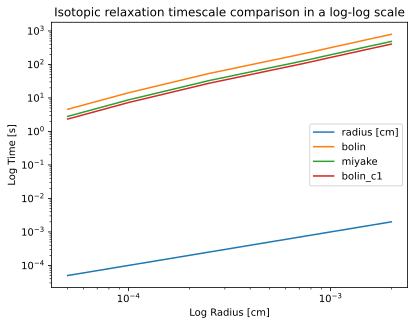

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for variant, time in adjustment_time.items():
    ax.loglog(radii, time * si.s, label=variant)
ax.set_title('Isotopic relaxation timescale comparison in a log-log scale')
ax.set_xlabel('Log Radius [cm]')
ax.set_ylabel('Log Time [s]')
ax.legend()
show_plot('timescales_comparison.pdf')

## 